# Ours

our code

In [63]:
from __future__ import print_function, division

import os
import math
from shutil import copyfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from torchvision.transforms import InterpolationMode

import numpy as np
import random

os.environ['TORCH_HOME']='./'

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [43]:
import imgaug.augmenters as iaa

import torch.utils.data as Data
from LPN.image_folder import *

environments = {'normal': iaa.Sequential([iaa.Noop()]),
                'dark' : iaa.Sequential([
                                        # iaa.BlendAlpha(0.5, foreground=iaa.Add(100), background=iaa.Multiply(0.2), seed=31),
                                        iaa.MultiplyAndAddToBrightness(mul=0.4, add=-15, seed=1991)]),
                'fog'  : iaa.Sequential([iaa.CloudLayer(intensity_mean=225, intensity_freq_exponent=-2, intensity_coarse_scale=2, alpha_min=1.0,
                                        alpha_multiplier=0.9, alpha_size_px_max=10, alpha_freq_exponent=-2, sparsity=0.9, density_multiplier=0.5, seed=35)]),
                'rain' : iaa.Sequential([iaa.Rain(drop_size=(0.05, 0.1), speed=(0.04, 0.06), seed=38),
                                        iaa.Rain(drop_size=(0.05, 0.1), speed=(0.04, 0.06), seed=35),
                                        iaa.Rain(drop_size=(0.1, 0.2), speed=(0.04, 0.06), seed=73),
                                        iaa.Rain(drop_size=(0.1, 0.2), speed=(0.04, 0.06), seed=93),
                                        iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=95)]),
                'snow' : iaa.Sequential([iaa.Snowflakes(flake_size=(0.5, 0.8), speed=(0.007, 0.03), seed=38),
                                        iaa.Snowflakes(flake_size=(0.5, 0.8), speed=(0.007, 0.03), seed=35),
                                        iaa.Snowflakes(flake_size=(0.6, 0.9), speed=(0.007, 0.03), seed=74),
                                        iaa.Snowflakes(flake_size=(0.6, 0.9), speed=(0.007, 0.03), seed=94),
                                        iaa.Snowflakes(flake_size=(0.5, 0.9), speed=(0.007, 0.03), seed=96)]),
                'fog_rain' : iaa.Sequential([iaa.CloudLayer(intensity_mean=225, intensity_freq_exponent=-2, intensity_coarse_scale=2, alpha_min=1.0,
                                            alpha_multiplier=0.9, alpha_size_px_max=10, alpha_freq_exponent=-2, sparsity=0.9, density_multiplier=0.5, seed=35),
                                            iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=35),
                                            iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=36)]),
                'fog_snow' : iaa.Sequential([iaa.CloudLayer(intensity_mean=225, intensity_freq_exponent=-2, intensity_coarse_scale=2, alpha_min=1.0,
                                            alpha_multiplier=0.9, alpha_size_px_max=10, alpha_freq_exponent=-2, sparsity=0.9, density_multiplier=0.5, seed=35),
                                            iaa.Snowflakes(flake_size=(0.5, 0.9), speed=(0.007, 0.03), seed=35),
                                            iaa.Snowflakes(flake_size=(0.5, 0.9), speed=(0.007, 0.03), seed=36)]),
                'rain_snow' : iaa.Sequential([iaa.Snowflakes(flake_size=(0.5, 0.8), speed=(0.007, 0.03), seed=35),
                                            iaa.Rain(drop_size=(0.05, 0.1), speed=(0.04, 0.06), seed=35),
                                            iaa.Rain(drop_size=(0.1, 0.2), speed=(0.04, 0.06), seed=92),
                                            iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=91),
                                            iaa.Snowflakes(flake_size=(0.6, 0.9), speed=(0.007, 0.03), seed=74)]),
                'light': iaa.Sequential([iaa.MultiplyAndAddToBrightness(mul=1.6, add=(0, 30), seed=1992)]),
                'wind' : iaa.Sequential([iaa.MotionBlur(15, seed=17)])
                }

environments2index = {env: idx for idx, env in enumerate(environments)}
index2environments = [i for i in environments]

class WeatherTransform:
    def __init__(self, aug='normal') -> None:
        self.transform = environments[aug]

    def __call__(self, img):
        img = np.array(img) # input is PIL
        img = self.transform(image=img)
        img = Image.fromarray(img)
        return img
    

class MyDataset(datasets.ImageFolder):
    # enable various weather enhancement
    # use for drone-view only
    def __init__(self, root, transform = None, target_transform = None, style='normal', h=384, w=384):
        super().__init__(root, transform = transform, target_transform = target_transform)
        self.envir_list = [i for i in environments]
        self.style_list = self.envir_list + ['mixed']
        assert style in self.style_list, f"style must be one of {self.style_list}"
        self.style = style 
        # assert stage in ['train', 'test'], f"style must be one of {['train', 'test']}"
        # self.stage = stage
         
        # transform setting
        self.h = h 
        self.w = w

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        # enhance image according to self.style 
        h = self.h 
        w = self.w 

        if self.style=='mixed':
            weather = np.random.choice(self.envir_list)
        else:
            weather = self.style


        t = transforms.Compose(
            [
                transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC),
                WeatherTransform(aug=weather),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        )
        
        img = t(img)
        return img, target, weather    

    def __len__(self):
        return len(self.imgs)
    
def label2tensor(label, num_classes=10):
    idxs = [environments2index[i] for i in label]
    idxs = torch.tensor(idxs) 
    t = torch.nn.functional.one_hot(idxs, num_classes=num_classes).float()
    return t

def tensor2label(t):
    indices = torch.argmax(t, dim=1)
    return [index2environments[i] for i in indices]



Test custom dataset(skip freely)

tensor([567, 575,  73, 667, 477, 197, 339, 319])
('light', 'light', 'rain_snow', 'fog_rain', 'wind', 'dark', 'snow', 'fog_rain')
['light', 'light', 'rain_snow', 'fog_rain', 'wind', 'dark', 'snow', 'fog_rain']


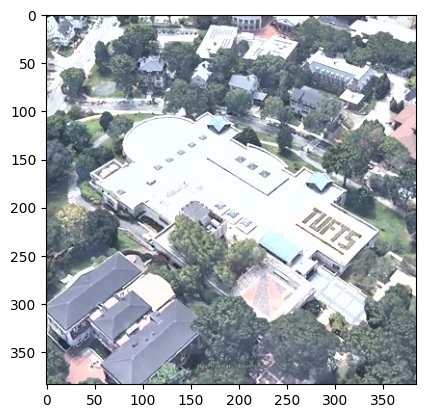

In [48]:
a = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'train', 'drone'), style='mixed')

from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show() 

d = torch.utils.data.DataLoader(a, batch_size=8, shuffle=True, num_workers=0, pin_memory=False)
dataiter = iter(d)
img, label, weather = dataiter.next()
#print(img.shape)
print(label)

print(weather)
x = label2tensor(weather)
xx = tensor2label(x)
print(xx)



imshow(img[0])

## CONVERT IMAGE TO TENSOR

In [59]:
from LPN.folder import ImageFolder
from LPN.image_folder import customData

def init_dataset_train(name='University-Release', w=384, h=384, pad=10, batchsize=8, style='mixed', num_worker=4):

    data_transforms = {
        'train': transforms.Compose(
            [
                transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC), 
                transforms.Pad( pad, padding_mode='edge'),
                transforms.RandomCrop((h, w)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ),
        'val': transforms.Compose(
            [
                transforms.Resize(size=(h, w),interpolation=InterpolationMode.BICUBIC), 
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ),
        'satellite': transforms.Compose(
            [
                transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC),
                transforms.Pad( pad, padding_mode='edge'),
                transforms.RandomAffine(90),
                transforms.RandomCrop((h, w)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ) 
    }   

    image_datasets = {
        'satellite': datasets.ImageFolder(os.path.join(os.getcwd(), name, 'train', 'satellite'), data_transforms['satellite']),
        'street': datasets.ImageFolder(os.path.join(os.getcwd(), name, 'train', 'street'), data_transforms['train']),
        'drone': MyDataset(os.path.join(os.getcwd(), name, 'train', 'drone'), style=style, h=h, w=w),
        'google': ImageFolder(os.path.join(os.getcwd(), name, 'train', 'google'), data_transforms['train'])
    }

    dataloaders = {
        'satellite': torch.utils.data.DataLoader(image_datasets['satellite'], batch_size=batchsize, shuffle=True, num_workers=num_worker, pin_memory=False),
        'street': torch.utils.data.DataLoader(image_datasets['street'], batch_size=batchsize, shuffle=True, num_workers=num_worker, pin_memory=False),
        'drone': torch.utils.data.DataLoader(image_datasets['drone'], batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False), # Must 0 here
        'google': torch.utils.data.DataLoader(image_datasets['google'], batch_size=batchsize, shuffle=True, num_workers=num_worker, pin_memory=False),
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
    return image_datasets, dataloaders, dataset_sizes

def init_dataset_test(name='University-Release', w=384, h=384, batchsize=128, style='mixed', num_worker=16):
    query_list = ['query_satellite', 'query_drone', 'query_street']
    gallery_list = ['gallery_satellite','gallery_drone', 'gallery_street']

    data_transforms = transforms.Compose([
        transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_datasets = {x: MyDataset(os.path.join(os.getcwd(), name, 'test', x), style=style,h=h, w=w)
                      if 'drone' in x 
                      else datasets.ImageFolder( os.path.join(name, 'test', x) ,data_transforms) 
                      for x in (query_list+gallery_list)}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=False, num_workers=0) 
                   if 'drone' in x 
                   else torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=False, num_workers=num_worker) 
                   for x in (query_list+gallery_list)}

    dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
    return image_datasets, dataloaders, dataset_sizes

## build a CNN network to classify weather

In [60]:
from torch import nn
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader

class WeatherCNN(nn.Module):
    def __init__(self, class_num=10, h=384, w=384, latent_dim=1000):
        super(WeatherCNN, self).__init__()
        self.w = w 
        self.h = h

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        fc_input_size = self.get_fc_input_size() # to dynamically calculate fc input size, since h,w changes
        self.fc1 = nn.Linear(fc_input_size, latent_dim)
        self.fc2 = nn.Linear(latent_dim, class_num)
        self.softmax = nn.Softmax(dim=-1)      

    def forward(self, xx):
        x = self.layer1(xx)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    def get_fc_input_size(self):
        dummy_imput = torch.zeros(1, 3, self.h, self.w)
        x = self.layer1(dummy_imput)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        return x.shape[1]
    
def pretrain_WeatherCNN(
                name='WeatherCNN',
                lr=0.001,
                num_epochs=60,
                batchsize=16,
                h=256,
                w=256,
                train_num=None,
                dataset='University-Release', 
                style='mixed'):
    # load Dataset
    image_datasets, dataloaders, dataset_sizes = init_dataset_train(name=dataset, w=w, h=h, style=style)

    if type(train_num) is int:
        indices = list(range(train_num))
        s_dataset = Subset(image_datasets['drone'], indices)
    else:
        s_dataset = image_datasets['drone']
    s_dataloader = DataLoader(s_dataset, batch_size=batchsize, shuffle=True, num_workers=0) 

    # Create Model
    model = WeatherCNN(h=h, w=w)
    model = model.cuda()
    model.train(True)  # Set model to training mode

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
     
    for epoch in range(1, num_epochs+1):     
        correct = 0 
        total = 0
        epoch_loss = 0
        for data in s_dataloader:                                
            # get the inputs
            inputs, labels, weather = data
            now_batch_size,c,h,w = inputs.shape
            if now_batch_size<batchsize: # skip the last batch
                continue
            wt = label2tensor(weather)
            if torch.cuda.is_available():
                inputs = inputs.cuda().detach()
                labels = labels.cuda().detach()
                wt = wt.cuda().detach()

            # zero the parameter gradients
            optimizer.zero_grad()

            wo = model(inputs)
            loss = criterion(wo, wt)
            sssss = tensor2label(wt)
            xxxxx = tensor2label(wo)

            for i in range(batchsize):
                if sssss[i] == xxxxx[i]:
                    correct = correct + 1
            total = total + batchsize
            epoch_loss += float(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()  
        print("Epoch: {} Loss: {:.4f} Acc: {:.4f}".format(epoch, epoch_loss, correct/total))

    # save pth
    if not os.path.isdir(os.path.join(os.getcwd(), "model", name)):
        os.mkdir(os.path.join(os.getcwd(), "model", name))
    save_filename = 'net_{:03d}_{}x{}.pth'.format(epoch, w, h)
    save_path = os.path.join(os.path.join(os.getcwd(), "model", name, save_filename))
    torch.save(model.cpu().state_dict(), save_path)

In [62]:
pretrain_WeatherCNN(train_num=32, w=256, h=256)

Epoch: 1 Loss: 4.6343 Acc: 0.1562
Epoch: 2 Loss: 4.6098 Acc: 0.1562
Epoch: 3 Loss: 4.9223 Acc: 0.0000
Epoch: 4 Loss: 4.7973 Acc: 0.0625
Epoch: 5 Loss: 4.7973 Acc: 0.0625
Epoch: 6 Loss: 4.7973 Acc: 0.0625
Epoch: 7 Loss: 4.4223 Acc: 0.2500
Epoch: 8 Loss: 4.4223 Acc: 0.2500
Epoch: 9 Loss: 4.6723 Acc: 0.1250
Epoch: 10 Loss: 4.8598 Acc: 0.0312
Epoch: 11 Loss: 4.7348 Acc: 0.0938
Epoch: 12 Loss: 4.8598 Acc: 0.0312
Epoch: 13 Loss: 4.7973 Acc: 0.0625
Epoch: 14 Loss: 4.7348 Acc: 0.0938
Epoch: 15 Loss: 4.6098 Acc: 0.1562
Epoch: 16 Loss: 4.7348 Acc: 0.0938
Epoch: 17 Loss: 4.6723 Acc: 0.1250
Epoch: 18 Loss: 4.8598 Acc: 0.0312
Epoch: 19 Loss: 4.9223 Acc: 0.0000
Epoch: 20 Loss: 4.6098 Acc: 0.1562
Epoch: 21 Loss: 4.6098 Acc: 0.1562
Epoch: 22 Loss: 4.8598 Acc: 0.0312
Epoch: 23 Loss: 4.6723 Acc: 0.1250
Epoch: 24 Loss: 4.6723 Acc: 0.1250
Epoch: 25 Loss: 4.8598 Acc: 0.0312
Epoch: 26 Loss: 4.7348 Acc: 0.0938
Epoch: 27 Loss: 4.6723 Acc: 0.1250
Epoch: 28 Loss: 4.6723 Acc: 0.1250
Epoch: 29 Loss: 4.7973 Acc: 0